Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

**IMPORTANT: DO NOT COPY OR SPLIT CELLS.** If you do, you'll mess the autograder. If need more cells to work or test things out, create a new cell. You may add as many new cells as you need.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and group below:

In [1]:
COURSE = "Unsupervised Learning 2021"
GROUP = "D8A"
NAME = "Tokiyomi" # Match your GitHub Classroom ID

---

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

%matplotlib inline

# Assignment: Anomaly and Outlier Detection

In this assignment you'll be required to implement different outlier detection algorithms.

- HBOS statistical method (TODO, skip)
- Distance matrix (1 pt)
- KNN (3 pts)
- LOF (3 pts)
- ABOD (3 pts)

We'll be using the wine dataset, from the sklearn example datasets.

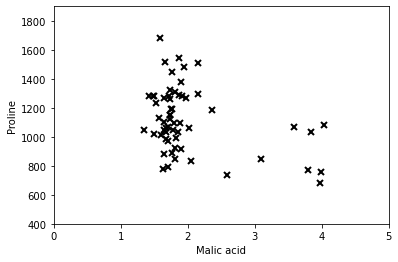

In [3]:
from sklearn.datasets import load_wine

# Select the first class (59 elements), columns 'Malic acid' and 'Proline' (see DESCR)
X = load_wine()['data'][:59, [1,12]]

# Normalize the data matrix, this step is important
# since the scale of the two columns differs significantly
from sklearn import preprocessing

X_scaled = preprocessing.MinMaxScaler().fit_transform(X)


#  Visualize the example dataset
plt.plot(X[:,0], X[:,1], 'bx', mew=2, mec='k', ms=6)
plt.axis([0, 5, 400, 1900])
plt.xlabel('Malic acid')
plt.ylabel('Proline');

## Distance matrix (1 pt)

Implement an algorithm to fnd the distance matrix, you will use this function for the next algorithms.

In [4]:
def distance_matrix(X):

    """Returns the distance matrix from a data matrix X. """

    D = np.sqrt(np.sum((X[:, None, :] - X[None, :, :])**2, axis = -1))
    # this takes up a lot of memory creating an (i, j, k)-shaped intermediate matrix
    
    return D

## K$^{th}$NN and KNN algorithm (3 pts)

Implement both algorithms in a single function, with a flag to decide which method to use.

In [5]:
def scores_knn(X, k, kth=False):
    """ Return the oulier scores given by the distance to the kth neighbor."""
    
    # Find the distance matrix
    # YOUR CODE HERE
    D = distance_matrix(X)
    
    # Sort the distance matrix row by row.
    # YOUR CODE HERE
    sorted_matrix = np.sort(D, axis=1)

    if kth:
        # Take the k column (excluding self distance)
        scores = sorted_matrix[:,k]
        
    else:
        # Take the average up to the k column (excluding self distance)
        # YOUR CODE HERE
        scores = np.mean(sorted_matrix[:,1:k+1], axis=1)
    
    return scores

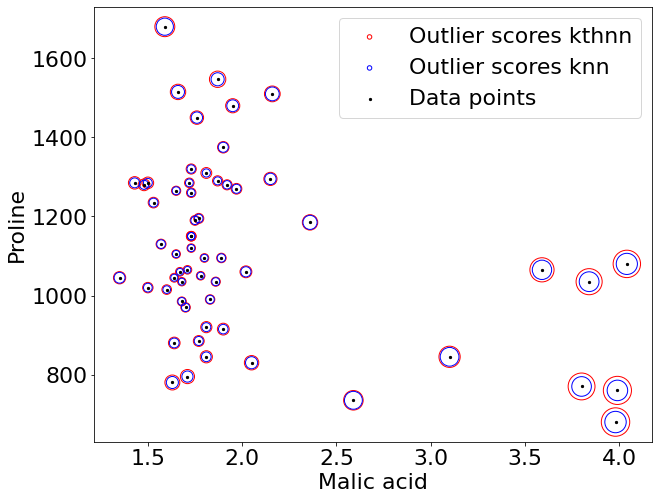

In [6]:
# Test your solution, compare with notes.

# Submitt with k=10, you may test other options
k = 10
kthnn_scores = scores_knn(X_scaled, k, kth=True)
knn_scores = scores_knn(X_scaled, k, kth=False)

plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(10,8))

plt.scatter(X[:,0], X[:,1], s=1000*kthnn_scores, edgecolors='r',
            facecolors='none', label='Outlier scores kthnn')
plt.scatter(X[:,0], X[:,1], s=1000*knn_scores, edgecolors='b',
            facecolors='none', label='Outlier scores knn')
plt.scatter(X[:,0], X[:,1], s=5, color='k', label='Data points')
legend = plt.legend()
legend.legendHandles[0]._sizes = [20]
legend.legendHandles[1]._sizes = [20]

plt.xlabel('Malic acid')
plt.ylabel('Proline');

## LOF (3 pts)

Implement the function to return the LOF score of each observation. If needed consult the notes or the original paper on LOF, attatched.

In [7]:
def lof(X, k):
    # Find the distance matrix
    # YOUR CODE HERE
    D = distance_matrix(X)
    np.fill_diagonal(D,np.inf) # with the aim of making self-distances go to the end of the sorted list

    # Sort the distance matrix row by row to obtain the k neighborhood of each row.
    sorted_matrix = np.sort(D, axis=1) 
    sorted_idx = np.argsort(D, axis=1)

    # Store the k-distance of each observation
    k_dist = sorted_matrix[:,k-1]

    # Also store the indices of the neighbors to find the k-distance of each point o.
    Nk_idx = sorted_idx[:,:k] 

    # Find the reachability distances of each neighborhood
    # Note: Numpy fancy indexing is your friend
 
    r_dist = np.zeros((len(X), k))
    for i, x in enumerate(X): # for each obs
        for j, o in enumerate(Nk_idx[i]): # for each neigh
            r_dist[i,j] = max(D[i,o], k_dist[o])

    # Find LRD for each observation
    """lrd_array = np.zeros(len(X))
    for i, x in enumerate(X): # por cada observacion
        sumatoria = 0
        for j, o in enumerate(Nk_idx[i]): # por cada vecino
            sumatoria += r_dist[i,j]
        lrd_array[i] = 1 / (sumatoria/k)"""

    lrd = 1 / np.mean(r_dist, axis=1)

    #Find LOF scores
    """lof_array = np.zeros(len(X))
    for i, x in enumerate(X): # por cada observacion
        sumatoria = 0
        for j, o in enumerate(Nk_idx[i]): # por cada vecino
            sumatoria += lrd_array[o]
        lof_array[i] = ((sumatoria)/k)/(lrd_array[i])

    scores = lof_array"""

    scores = (np.sum(lrd[Nk_idx], axis = 1)/lrd)/k

    return scores

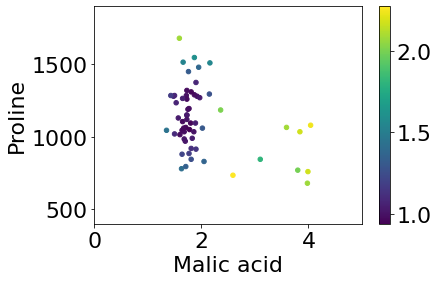

In [8]:
# Submitt ussing k=10, you may test different values.
k = 10
lof_scores = lof(X_scaled, k)

plt.scatter(X[:,0], X[:,1], s=20, c=lof_scores)
plt.colorbar()

plt.axis([0, 5, 400, 1900])
plt.xlabel('Malic acid')
plt.ylabel('Proline');

## ABOD (3 pts)

Implement the function to return the ABOF score of each observation. If needed consult the notes or the original paper on ABOD, attatched.

In [9]:
def abof(a, X):
    """ Returns abof score for X[a] """

    m = len(X)
    X_a = X[a] # Set the A point

    # Variablea to store the first and second terms of the varince
    var1 = 0
    var2 = 0
    # variable to store the normalization constant (sum of weights)
    norm_c = 0

    # Loop over all pairs of points
    for b in range(m):
        if a == b:
            continue
        for c in range(b+1, m):
            if a == c:
                continue
            
            # Set the B and C points
            X_b = X[b]
            X_c = X[c]

            # Compute AB and AC vectors
            AB = X_b - X_a
            AC = X_c - X_a

            # Avoid division by zero
            if np.linalg.norm(AB) == 0 or np.linalg.norm(AC) == 0:
                continue

            # Compute up and down parts
            norm_c += (1/(np.linalg.norm(AB) * np.linalg.norm(AC)))
            norm_c_act = (np.linalg.norm(AB) * np.linalg.norm(AC))
            cos_angle = (np.dot(AB,AC) / norm_c_act**2)
            
            # Compute var_1
            var1 += (((1/norm_c_act)*cos_angle)**2)

            # Compute var_2
            var2 += ((1/norm_c_act)*cos_angle)

    var = var1/norm_c - (var2/norm_c)**2

    return var

In [10]:
def abod(X):
    """ Retrun abof scores for X """
    
    scores = []
    for a in range(len(X)):
        scores.append(abof(a, X))

    return np.array(scores)

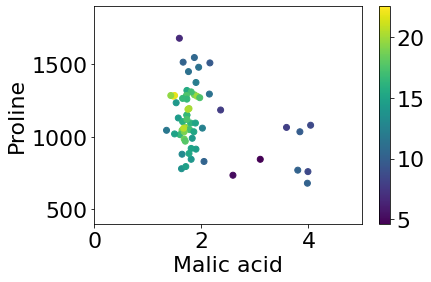

In [11]:
# Submitt ussing k=10, you may test different values.
k = 10
abod_scores = abod(X_scaled)

plt.scatter(X[:,0], X[:,1], c=np.log(abod_scores))
plt.colorbar()

plt.axis([0, 5, 400, 1900])
plt.xlabel('Malic acid')
plt.ylabel('Proline');